Loading DEM: C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\dem_blantyre_clipped.tif
Original DEM shape: (2398, 1492) CRS: EPSG:4326
Selected UTM EPSG:32736 based on centroid lon 34.925
Reprojecting DEM to metric CRS (this may take a few seconds)...
Reprojected DEM shape: (2432, 1480) cellsize (m): 30.476812971863257
Filling sinks (this may take a short while)...
Sink-filling complete.
Computing D8 flow directions...
Flow direction computed.
Computing flow accumulation (this may take several seconds)...
Flow accumulation computed. processed cells: 2158352
Extracting streams using threshold = 500 upstream cells...
Saving flow accumulation raster...
Saving flow direction raster (0..7 codes)...
Saving stream binary raster...
Vectorizing stream raster to vector polygons (approximate)...
Stream shapes saved: C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\streams_vector.shp
Determining pour point...
No manual pour point provided. Using river shapefile to pick a downst

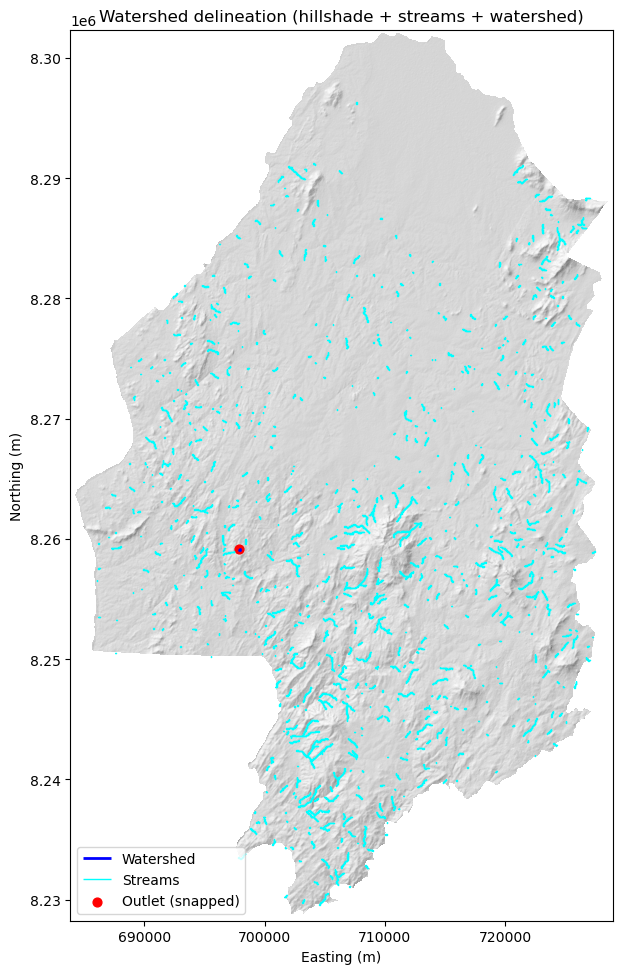

Enhanced PNG saved: C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\watershed_map.png
All outputs saved to project folder.
Files created:
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\flowdir_d8.tif 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\flowaccum_d8.tif 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\streams_d8.tif 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\watershed_mask.tif 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\watershed_polygon.shp 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\streams_vector.shp 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\watershed_stats.txt 
 C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)\watershed_map.png


In [2]:
# ======= Watershed delineation (Manual pour point) =======
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
import numpy as np
import geopandas as gpd
from shapely.geometry import shape, Point, mapping
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import warnings
warnings.filterwarnings('ignore')

# --- USER CONFIGURE ---
project_folder = r"C:\Users\DELL\projects\Groundwater Potential Mapping (GPM)"  # adjust if needed
dem_path = os.path.join(project_folder, "dem_blantyre_clipped.tif")
rivers_shp = os.path.join(project_folder, "mw-main rivers-50k.shp")

# Output filenames
out_flowdir = os.path.join(project_folder, "flowdir_d8.tif")
out_accum = os.path.join(project_folder, "flowaccum_d8.tif")
out_stream_raster = os.path.join(project_folder, "streams_d8.tif")
out_watershed_raster = os.path.join(project_folder, "watershed_mask.tif")
out_watershed_shp = os.path.join(project_folder, "watershed_polygon.shp")
out_streams_shp = os.path.join(project_folder, "streams_vector.shp")
out_stats_txt = os.path.join(project_folder, "watershed_stats.txt")
out_png = os.path.join(project_folder, "watershed_map.png")

# Set pour point manually (lon, lat) in DEM's original CRS, or None to use river shapefile to pick one.
# Example: pour_point_lonlat = (35.0, -15.7)  # (lon, lat)
pour_point_lonlat = None

# Stream extraction threshold (number of upstream cells). Tune as needed.
stream_threshold = 500

# Maximum iterations for sink-filling (safety)
max_fill_iter = 2000

# =========================================================

print("Loading DEM:", dem_path)
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype('float64')
    dem_meta = src.meta.copy()
    dem_crs = src.crs
    dem_transform = src.transform
    dem_bounds = src.bounds
    nodata = src.nodata
    src_res = (src.transform.a, -src.transform.e)  # (xres, yres)

print("Original DEM shape:", dem.shape, "CRS:", dem_crs)

# --- Reproject DEM to a metric UTM zone for accurate distances/areas ---
# compute centroid lon/lat to pick UTM zone
transformer_to_wgs = None
if dem_crs and dem_crs.is_geographic:
    # need to compute centroid lon/lat from bounds
    cx = (dem_bounds.left + dem_bounds.right) / 2.0
    cy = (dem_bounds.bottom + dem_bounds.top) / 2.0
    centroid_lon, centroid_lat = cx, cy
else:
    # transform center to lon/lat
    src_crs = dem_crs
    dst_crs = CRS.from_epsg(4326)
    transformer_to_wgs = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    cx = (dem_bounds.left + dem_bounds.right) / 2.0
    cy = (dem_bounds.bottom + dem_bounds.top) / 2.0
    centroid_lon, centroid_lat = transformer_to_wgs.transform(cx, cy)

zone = int((centroid_lon + 180) // 6) + 1
utm_epsg = 32700 + zone  # southern hemisphere UTM
print(f"Selected UTM EPSG:{utm_epsg} based on centroid lon {centroid_lon:.3f}")

dst_crs = CRS.from_epsg(utm_epsg)
# calculate transform & shape for reprojection
dst_transform, dst_width, dst_height = calculate_default_transform(
    dem_crs, dst_crs, dem_meta['width'], dem_meta['height'], *dem_bounds)
dst_meta = dem_meta.copy()
dst_meta.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})

# reproject DEM into metric CRS
print("Reprojecting DEM to metric CRS (this may take a few seconds)...")
dem_utm = np.zeros((dst_height, dst_width), dtype=np.float64)
reproject(
    source=dem,
    destination=dem_utm,
    src_transform=dem_transform,
    src_crs=dem_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear,
    src_nodata=nodata,
    dst_nodata=np.nan
)
cellsize_x = dst_transform.a
cellsize_y = -dst_transform.e
cellsize = (abs(cellsize_x) + abs(cellsize_y)) / 2.0
print("Reprojected DEM shape:", dem_utm.shape, "cellsize (m):", cellsize)

# Replace nodata (if any) with np.nan
dem_utm = np.where(np.isfinite(dem_utm), dem_utm, np.nan)

# ----------------------------
# 1) Simple sink-fill (iterative lower-bound fill)
# ----------------------------
def fill_depressions_simple(arr, max_iter=1000, tol=1e-6):
    """
    Simple iterative sink filling:
    For each cell, compute min neighbor elevation; if cell < min_neighbor, raise to min_neighbor.
    Repeat until no change or max_iter reached.
    Works for moderate-sized DEMs. Not performance-optimal but robust.
    """
    a = arr.copy()
    rows, cols = a.shape
    # pad with np.nan to simplify neighbor min calculation
    for it in range(max_iter):
        old_min = np.nanmin(a)
        # compute neighbor minima
        neigh_min = np.full_like(a, np.nan)
        # use rolling windows (8 neighbors)
        shifts = [(-1, -1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        mins = []
        for dy, dx in shifts:
            rolled = np.roll(np.roll(a, dy, axis=0), dx, axis=1)
            # invalidate rolled edges
            if dy == -1:
                rolled[-1,:] = np.nan
            if dy == 1:
                rolled[0,:] = np.nan
            if dx == -1:
                rolled[:, -1] = np.nan
            if dx == 1:
                rolled[:, 0] = np.nan
            mins.append(rolled)
        neigh_min = np.nanmin(np.array(mins), axis=0)
        # For cells that are lower than neigh_min, raise them
        mask = (a < neigh_min)
        if not np.any(mask):
            # no changes -> finished
            break
        a[mask] = neigh_min[mask]
    return a

print("Filling sinks (this may take a short while)...")
filled_dem = fill_depressions_simple(dem_utm, max_iter=max_fill_iter)
print("Sink-filling complete.")

# ----------------------------
# 2) Compute D8 flow direction (each cell points to neighbor with min elevation)
#    We'll store flow direction as an index to neighbor:
#    directions: 0..7 correspond to neighbors in order: 
#    [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]
# ----------------------------
neighbors = [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]
nr, nc = filled_dem.shape
flow_dir = np.full_like(filled_dem, fill_value=-1, dtype=np.int8)  # -1 = no data / flat

print("Computing D8 flow directions...")
# pad to handle edges
for r in range(1, nr-1):
    for c in range(1, nc-1):
        if np.isnan(filled_dem[r,c]):
            continue
        vals = []
        for i, (dr, dc) in enumerate(neighbors):
            nr_r, nr_c = r + dr, c + dc
            v = filled_dem[nr_r, nr_c]
            vals.append(v)
        vals = np.array(vals)
        # pick neighbor with minimum elevation
        if np.all(np.isnan(vals)):
            continue
        min_idx = int(np.nanargmin(vals))
        flow_dir[r,c] = min_idx

# handle edges by assigning no flow (still -1)
print("Flow direction computed.")

# ----------------------------
# 3) Compute flow accumulation using topological approach:
#    - First compute for each cell how many neighbors flow into it (in-degree)
#    - Push cells with in-degree == 0 to a queue
#    - Pop and propagate their accumulation downstream
# ----------------------------
print("Computing flow accumulation (this may take several seconds)...")
# create arrays to map cell linear index
lin_index = lambda r,c: r*nc + c
down_idx = np.full(nr*nc, -1, dtype=np.int32)  # linear index of downstream cell or -1

# Build downstream mapping
for r in range(1, nr-1):
    for c in range(1, nc-1):
        idx = lin_index(r,c)
        d = flow_dir[r,c]
        if d >= 0:
            dr, dc = neighbors[d]
            rr, cc = r + dr, c + dc
            down_idx[idx] = lin_index(rr, cc)

# compute in-degree (how many cells flow into each cell)
in_degree = np.zeros(nr*nc, dtype=np.int32)
for idx in range(nr*nc):
    di = down_idx[idx]
    if di >= 0:
        in_degree[di] += 1

# initialize accumulation with 1 (each cell contributes 1)
acc = np.ones(nr*nc, dtype=np.float64)
# set cells that are NaN in DEM to 0 accumulation and treat as sinks
mask_valid = ~np.isnan(filled_dem).ravel()
acc[~mask_valid] = 0.0

# queue of cells with in-degree == 0
from collections import deque
q = deque(np.where((in_degree == 0) & mask_valid)[0].tolist())

proc_count = 0
while q:
    idx = q.popleft()
    di = down_idx[idx]
    if di >= 0:
        acc[di] += acc[idx]
        in_degree[di] -= 1
        if in_degree[di] == 0:
            q.append(di)
    proc_count += 1
# reshape acc
flow_acc = acc.reshape((nr, nc))
print("Flow accumulation computed. processed cells:", proc_count)

# ----------------------------
# 4) Extract streams by thresholding accumulation
# ----------------------------
print(f"Extracting streams using threshold = {stream_threshold} upstream cells...")
streams = (flow_acc >= stream_threshold).astype(np.uint8)

# Save rasters (flow accumulation, flow direction index, streams)
def save_raster(arr, out_path, meta, dtype=rasterio.float32):
    m = meta.copy()
    m.update({
        'count': 1,
        'dtype': dtype,
        'crs': dst_crs,
        'transform': dst_transform,
        'width': arr.shape[1],
        'height': arr.shape[0],
        'compress': 'lzw'
    })
    
    # assign valid nodata depending on dtype
    if dtype in (rasterio.uint8, rasterio.uint16, rasterio.int16):
        m['nodata'] = 0
        arr_clean = np.where(np.isfinite(arr), arr, 0)
    else:
        m['nodata'] = np.nan
        arr_clean = arr.astype(dtype)

    with rasterio.open(out_path, 'w', **m) as dst:
        dst.write(arr_clean.astype(dtype), 1)

print("Saving flow accumulation raster...")
save_raster(flow_acc, out_accum, dem_meta, dtype=rasterio.float32)

print("Saving flow direction raster (0..7 codes)...")
save_raster(flow_dir, out_flowdir, dem_meta, dtype=rasterio.uint8)

print("Saving stream binary raster...")
save_raster(streams, out_stream_raster, dem_meta, dtype=rasterio.uint8)

# ----------------------------
# 5) Vectorize streams (polygons) and simplify to lines (approx)
# ----------------------------
print("Vectorizing stream raster to vector polygons (approximate)...")
with rasterio.open(out_stream_raster) as src:
    stream_data = src.read(1)
    transform = src.transform
    stream_shapes = list(shapes(stream_data, mask=stream_data.astype(bool), transform=transform))

stream_geoms = []
for geom, val in stream_shapes:
    if val == 1:
        stream_geoms.append(shape(geom))

gdf_streams = gpd.GeoDataFrame({'value':[1]*len(stream_geoms)}, geometry=stream_geoms, crs=dst_crs)
# convert polygons to centrelines or use centroids - for simple length measure use polygon area->approx length
# Save streams polygons
gdf_streams.to_file(out_streams_shp)
print("Stream shapes saved:", out_streams_shp)

# ----------------------------
# 6) Determine pour point (manual or from rivers shapefile)
# ----------------------------
print("Determining pour point...")
if pour_point_lonlat is not None:
    # user-specified in original DEM CRS
    user_lon, user_lat = pour_point_lonlat
    # transform to UTM CRS
    transformer = Transformer.from_crs(dem_crs, dst_crs, always_xy=True)
    px, py = transformer.transform(user_lon, user_lat)
    print("Using user-provided pour point (transformed to UTM):", px, py)
else:
    # Use rivers shapefile to pick a downstream-most / lowest elevation vertex
    print("No manual pour point provided. Using river shapefile to pick a downstream vertex as pour point...")
    rivers = gpd.read_file(rivers_shp)
    rivers = rivers.to_crs(dst_crs)
    # explode multipart and get all vertices
    rivers_expl = rivers.explode(index_parts=False).reset_index(drop=True)
    # get all line vertices into points and pick the lowest-elevation vertex (based on DEM)
    min_elev = 1e12
    chosen_pt = None
    print("Scanning river vertices to find lowest-elevation downstream vertex (this may take some seconds)...")
    for geom in rivers_expl.geometry:
        if geom is None:
            continue
        # sample several points along the line (densify for robust pick)
        coords = list(geom.coords)
        for (x, y) in coords:
            # map x,y to raster index
            col, row = ~dst_transform * (x, y)
            col = int(np.floor(col)); row = int(np.floor(row))
            if 0 <= row < nr and 0 <= col < nc:
                elev = filled_dem[row, col]
                if np.isfinite(elev) and elev < min_elev:
                    min_elev = elev
                    chosen_pt = (x, y)
    if chosen_pt is None:
        raise RuntimeError("Could not find candidate pour point from rivers shapefile. Consider specifying pour_point_lonlat manually.")
    px, py = chosen_pt
    print("Picked pour point from rivers shapefile at UTM coords:", (px, py), "elevation", min_elev)

# --- Snap pour point to nearest stream cell (by distance to raster cell centers where streams==1)
# convert raster coordinates to array indices and find nearest stream cell
cols_idx, rows_idx = np.where(streams == 1)
if len(cols_idx) == 0:
    raise RuntimeError("No stream cells found with the current threshold. Lower stream_threshold and rerun.")
# compute cell centers coords
xs = dst_transform.c + cols_idx * dst_transform.a + dst_transform.a / 2.0
ys = dst_transform.f + rows_idx * dst_transform.e + dst_transform.e / 2.0
# compute distances
d2 = (xs - px)**2 + (ys - py)**2
best = np.argmin(d2)
snap_col = cols_idx[best]
snap_row = rows_idx[best]
snap_x = xs[best]; snap_y = ys[best]
print("Snapped pour point to stream cell at row,col:", (snap_row, snap_col), "UTM coords:", (snap_x, snap_y))

# mark outlet linear index
outlet_idx = snap_row * nc + snap_col

# ----------------------------
# 7) Delineate watershed: find all cells that drain to the outlet by traversing reverse graph
# ----------------------------
print("Delineating watershed (walking upstream)...")
# build upstream adjacency list (list of lists)
upstream_lists = [[] for _ in range(nr*nc)]
for idx in range(nr*nc):
    di = down_idx[idx]
    if di >= 0:
        upstream_lists[di].append(idx)

# BFS/stack from outlet upstream to collect all contributing cells
mask_idxs = set()
stack = [outlet_idx]
while stack:
    cur = stack.pop()
    if cur in mask_idxs:
        continue
    mask_idxs.add(cur)
    for up in upstream_lists[cur]:
        if up not in mask_idxs:
            stack.append(up)

ws_mask = np.zeros((nr, nc), dtype=np.uint8)
for idx in mask_idxs:
    r = idx // nc
    c = idx % nc
    ws_mask[r, c] = 1

# Save watershed raster
save_raster(ws_mask, out_watershed_raster, dem_meta, dtype=rasterio.uint8)
print("Watershed raster saved:", out_watershed_raster)

# Vectorize watershed raster to polygon (take largest polygon)
with rasterio.open(out_watershed_raster) as src:
    mask_data = src.read(1)
    transform = src.transform
    shapes_gen = list(shapes(mask_data, mask=mask_data.astype(bool), transform=transform))

if not shapes_gen:
    raise RuntimeError("No watershed polygon produced.")
# choose the polygon with largest area
polys = [(shape(geom), val) for geom, val in shapes_gen if val == 1]
if len(polys) == 0:
    raise RuntimeError("No watershed polygon found after vectorization.")
# select largest
areas = [poly.area for poly, v in polys]
largest_idx = int(np.argmax(areas))
watershed_poly = polys[largest_idx][0]
gdf_ws = gpd.GeoDataFrame({'id':[1]}, geometry=[watershed_poly], crs=dst_crs)
gdf_ws.to_file(out_watershed_shp)
print("Watershed polygon saved:", out_watershed_shp)

# ----------------------------
# 8) Compute basin statistics
# ----------------------------
print("Computing basin statistics...")
# area (m^2)
area_m2 = gdf_ws.geometry.to_crs(epsg=3857).area.values[0]
area_km2 = area_m2 / 1e6

# mask DEM to watershed to compute mean elevation & slope
ws_rows, ws_cols = np.where(ws_mask == 1)
if len(ws_rows) == 0:
    raise RuntimeError("Watershed mask empty.")
minr, maxr = ws_rows.min(), ws_rows.max()
minc, maxc = ws_cols.min(), ws_cols.max()
# compute mean elevation for masked cells
masked_elev = filled_dem[ws_mask == 1]
mean_elev = float(np.nanmean(masked_elev))
median_elev = float(np.nanmedian(masked_elev))

# approximate slope using gradients
gy, gx = np.gradient(filled_dem, cellsize, cellsize)
slope_deg = np.degrees(np.arctan(np.sqrt(gx*gx + gy*gy)))
mean_slope = float(np.nanmean(slope_deg[ws_mask == 1]))

# total stream length: vectorize stream polygons and compute length in meters
gdf_streams = gdf_streams.to_crs(epsg=3857)
total_stream_length_m = gdf_streams.geometry.length.sum()
total_stream_length_km = total_stream_length_m / 1000.0

# write stats to file & print
stats = {
    'area_km2': area_km2,
    'mean_elevation_m': mean_elev,
    'median_elevation_m': median_elev,
    'mean_slope_deg': mean_slope,
    'total_stream_length_km': total_stream_length_km,
    'stream_threshold': stream_threshold
}
with open(out_stats_txt, 'w') as f:
    for k, v in stats.items():
        f.write(f"{k}: {v}\n")
print("Watershed statistics:")
for k, v in stats.items():
    print(f"  {k}: {v}")

# ----------------------------
# 9) Create a publication-ready PNG: hillshade + watershed polygon + streams overlay
# ----------------------------
print("Creating enhanced map PNG...")
# compute hillshade from filled_dem (in UTM)
def hillshade(elev, azimuth=315, angle_altitude=45):
    x, y = np.gradient(elev, cellsize, cellsize)
    slope = np.pi/2.0 - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    az = np.radians(azimuth)
    alt = np.radians(angle_altitude)
    hs = np.sin(alt)*np.sin(slope) + np.cos(alt)*np.cos(slope)*np.cos(az - aspect)
    return hs

hs = hillshade(filled_dem)

fig, ax = plt.subplots(1,1,figsize=(12,10))
# show hillshade
extent = [dst_transform.c, dst_transform.c + dst_transform.a * nr, dst_transform.f + dst_transform.e * nc, dst_transform.f]
# careful: extent order for imshow: left,right,bottom,top in x,y
left = dst_transform.c
right = dst_transform.c + dst_transform.a * nc
bottom = dst_transform.f + dst_transform.e * nr
top = dst_transform.f
ax.imshow(hs, cmap='gray', extent=(left, right, bottom, top), alpha=0.7)

# show classified watershed overlay (transparent)
# convert watershed polygon to plotting
gdf_ws_plot = gdf_ws.to_crs(epsg=dst_crs.to_epsg())
gdf_ws_plot.boundary.plot(ax=ax, linewidth=2, edgecolor='blue', label='Watershed')

# plot streams (in UTM)
gdf_streams_utm = gdf_streams.to_crs(epsg=dst_crs.to_epsg())
gdf_streams_utm.geometry.boundary.plot(ax=ax, linewidth=1, color='cyan', label='Streams')

# plot snapped pour point
ax.scatter([snap_x], [snap_y], color='red', s=40, label='Outlet (snapped)')

ax.set_title('Watershed delineation (hillshade + streams + watershed)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
print("Enhanced PNG saved:", out_png)

print("All outputs saved to project folder.")
print("Files created:\n", out_flowdir, "\n", out_accum, "\n", out_stream_raster, "\n", out_watershed_raster, "\n", out_watershed_shp, "\n", out_streams_shp, "\n", out_stats_txt, "\n", out_png)
